In [2]:
import operator
import psycopg2 as pg
import pandas as pd
import pandas.io.sql as pd_sql
import numpy as np

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

%matplotlib inline

# modelling imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler


In [3]:
# Postgres info to connect

connection_args = {
    'host': 'localhost',
    'dbname': 'nfl_db',
    'port': 5432
}

connection = pg.connect(**connection_args) # Unpacks dictionary keys and values

In [4]:
# initial preview of table

query = "SELECT * FROM nfl_plays LIMIT 10;"
pd_sql.read_sql(query, connection)

,index,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
1,1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
2,2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
3,3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
4,4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
5,5,162,2009091000,PIT,TEN,TEN,away,PIT,TEN,98.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
6,6,183,2009091000,PIT,TEN,TEN,away,PIT,TEN,98.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
7,7,207,2009091000,PIT,TEN,TEN,away,PIT,TEN,94.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
8,8,228,2009091000,PIT,TEN,TEN,away,PIT,TEN,96.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0
9,9,253,2009091000,PIT,TEN,PIT,home,TEN,TEN,43.0,...,None,None,None,0,None,None,0.0,0.0,0.0,0.0


In [5]:
# find information on all columns

query = "SELECT * FROM INFORMATION_SCHEMA.COLUMNS WHERE TABLE_NAME = N'nfl_plays';"
pd_sql.read_sql(query, connection)

,table_catalog,table_schema,table_name,column_name,ordinal_position,column_default,is_nullable,data_type,character_maximum_length,character_octet_length,...,is_identity,identity_generation,identity_start,identity_increment,identity_maximum,identity_minimum,identity_cycle,is_generated,generation_expression,is_updatable
0,nfl_db,public,nfl_plays,index,1,None,YES,bigint,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
1,nfl_db,public,nfl_plays,play_id,2,None,YES,bigint,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
2,nfl_db,public,nfl_plays,game_id,3,None,YES,bigint,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES
3,nfl_db,public,nfl_plays,home_team,4,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
4,nfl_db,public,nfl_plays,away_team,5,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
5,nfl_db,public,nfl_plays,posteam,6,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
6,nfl_db,public,nfl_plays,posteam_type,7,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
7,nfl_db,public,nfl_plays,defteam,8,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
8,nfl_db,public,nfl_plays,side_of_field,9,None,YES,text,None,1.073742e+09,...,NO,None,None,None,None,None,NO,NEVER,None,YES
9,nfl_db,public,nfl_plays,yardline_100,10,None,YES,double precision,None,NaN,...,NO,None,None,None,None,None,NO,NEVER,None,YES


In [6]:
# check play_types of plays with negative yards gained

query = "SELECT play_type, COUNT(*) FROM nfl_plays WHERE yards_gained < 0 GROUP BY play_type;"

pd_sql.read_sql(query, connection)

,play_type,count
0,pass,13988
1,punt,1
2,qb_kneel,3588
3,run,13157


In [7]:
# check yard loss play details **NEED TO RENAME COLUMN 'desc' TO 'description'**

query = "SELECT game_date, qtr, time, home_team, description, play_type, yards_gained, yardline_100\
        FROM nfl_plays WHERE yards_gained < 0 AND game_date > '2018-11-01' ORDER BY yards_gained ASC LIMIT 20;"

pd.set_option('display.max_colwidth', -1)
pd_sql.read_sql(query, connection)

,game_date,qtr,time,home_team,description,play_type,yards_gained,yardline_100
0,2018-12-02,4,08:26:00,DET,"(8:26) M.Stafford sacked at DET 29 for -13 yards (A.Donald). FUMBLES (A.Donald) [A.Donald], RECOVERED by LA-S.Ebukam at DET 24. S.Ebukam to DET 24 for no gain (L.Toilolo).",pass,-18.0,58.0
1,2018-12-16,4,00:24:00,CHI,"(:24) (Shotgun) A.Rodgers sacked at CHI 27 for -18 yards (L.Floyd). Penalty on GB, Illegal Shift, declined.",pass,-18.0,9.0
2,2018-12-09,1,01:34:00,GB,"(1:34) (Shotgun) M.Ryan sacked at GB 26 for -7 yards. FUMBLES, recovered by ATL-T.Coleman at GB 35. T.Coleman to GB 35 for no gain (J.Alexander).",pass,-16.0,19.0
3,2018-11-19,3,13:38:00,LA,"(13:38) (Shotgun) P.Mahomes sacked at LA 36 for -11 yards (A.Donald). FUMBLES (A.Donald) [A.Donald], touched at LA 41, RECOVERED by LA-J.Franklin at KC 46. J.Franklin to KC 46 for no gain (A.Reiter).",pass,-16.0,25.0
4,2018-12-02,4,09:20:00,SEA,(9:20) G.Fant reported in as eligible. R.Wilson sacked at SF 17 for -16 yards (R.Blair).,pass,-16.0,1.0
5,2018-11-11,4,06:08:00,LA,"(6:08) (Shotgun) R.Wilson sacked at SEA 23 for -9 yards (D.Fowler). FUMBLES (D.Fowler), touched at SEA 17, RECOVERED by LA-D.Fowler at SEA 9. D.Fowler to SEA 9 for no gain (J.Simmons).",pass,-15.0,68.0
6,2018-11-11,2,11:20:00,OAK,"(11:20) (Shotgun) D.Carr sacked at LAC 30 for -9 yards (M.Ingram). FUMBLES (M.Ingram) [M.Ingram], RECOVERED by LAC-C.Liuget at LAC 36. C.Liuget to OAK 40 for 24 yards (J.Richard). 4-yards loose ball yardage.",pass,-15.0,21.0
7,2018-11-11,4,06:08:00,LA,"(6:08) (Shotgun) R.Wilson sacked at SEA 23 for -9 yards (D.Fowler). FUMBLES (D.Fowler), touched at SEA 17, RECOVERED by LA-D.Fowler at SEA 9. D.Fowler to SEA 9 for no gain (J.Simmons).",pass,-15.0,68.0
8,2018-11-11,2,11:20:00,OAK,"(11:20) (Shotgun) D.Carr sacked at LAC 30 for -9 yards (M.Ingram). FUMBLES (M.Ingram) [M.Ingram], RECOVERED by LAC-C.Liuget at LAC 36. C.Liuget to OAK 40 for 24 yards (J.Richard). 4-yards loose ball yardage.",pass,-15.0,21.0
9,2018-12-15,4,13:18:00,NYJ,(13:18) (Shotgun) D.Watson sacked at NYJ 31 for -14 yards (J.Adams).,pass,-14.0,17.0


In [8]:
# check play_types of plays with zero yards gained

query = "SELECT play_type, COUNT(*) FROM nfl_plays WHERE yards_gained = 0 GROUP BY play_type;"

pd_sql.read_sql(query, connection)

,play_type,count
0,extra_point,10934
1,field_goal,9777
2,kickoff,25552
3,no_play,42417
4,pass,67832
5,punt,23913
6,qb_kneel,235
7,qb_spike,690
8,run,12391
9,None,12874


In [9]:
# check play_types of plays with positive yards gained

query = "SELECT play_type, COUNT(*) FROM nfl_plays WHERE yards_gained > 0 GROUP BY play_type;"

pd_sql.read_sql(query, connection)

,play_type,count
0,no_play,14
1,pass,104753
2,qb_kneel,4
3,run,107038


In [10]:
# create dataframe from selected columns

query = "SELECT play_id, game_date, yards_gained, play_type, home_team, away_team, posteam, \
        posteam_type, ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, goal_to_go, \
        ydstogo, shotgun, no_huddle, qb_dropback, qb_kneel, qb_spike, qb_scramble \
        FROM nfl_plays \
        WHERE play_type IN ('pass','run');"

df = pd_sql.read_sql(query, connection)

In [11]:
df.head()

,play_id,game_date,yards_gained,play_type,home_team,away_team,posteam,posteam_type,ydsnet,yardline_100,...,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble
0,68,2009-09-10,5.0,pass,PIT,TEN,PIT,home,5,58.0,...,1,1.0,0.0,10,0,0,1.0,0,0,0
1,92,2009-09-10,-3.0,run,PIT,TEN,PIT,home,2,53.0,...,1,2.0,0.0,5,0,0,0.0,0,0,0
2,113,2009-09-10,0.0,pass,PIT,TEN,PIT,home,2,56.0,...,1,3.0,0.0,8,1,0,1.0,0,0,0
3,162,2009-09-10,0.0,run,PIT,TEN,TEN,away,0,98.0,...,1,1.0,0.0,10,0,0,0.0,0,0,0
4,183,2009-09-10,4.0,pass,PIT,TEN,TEN,away,4,98.0,...,1,2.0,0.0,10,0,0,1.0,0,0,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319369 entries, 0 to 319368
Data columns (total 21 columns):
play_id                      319369 non-null int64
game_date                    319369 non-null object
yards_gained                 319159 non-null float64
play_type                    319369 non-null object
home_team                    319369 non-null object
away_team                    319369 non-null object
posteam                      319369 non-null object
posteam_type                 319369 non-null object
ydsnet                       319369 non-null int64
yardline_100                 319369 non-null float64
quarter_seconds_remaining    319369 non-null float64
qtr                          319369 non-null int64
down                         318691 non-null float64
goal_to_go                   319369 non-null float64
ydstogo                      319369 non-null int64
shotgun                      319369 non-null int64
no_huddle                    319369 non-null int64
qb_dro

In [13]:
# count how many rows have NaNs

df1 = df[df.isnull().any(axis=1)]
df1

,play_id,game_date,yards_gained,play_type,home_team,away_team,posteam,posteam_type,ydsnet,yardline_100,...,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble
720,2996,2009-09-13,0.0,run,IND,JAC,JAC,away,58,2.0,...,4,NaN,0.0,0,0,0,0.0,0,0,0
855,3721,2009-09-13,0.0,pass,CIN,DEN,DEN,away,87,2.0,...,4,NaN,0.0,0,0,0,1.0,0,0,0
1709,3768,2009-09-13,2.0,pass,GB,CHI,GB,home,72,2.0,...,4,NaN,0.0,0,0,0,1.0,0,0,0
1828,3778,2009-09-14,0.0,pass,NE,BUF,NE,home,81,2.0,...,4,NaN,0.0,0,0,0,1.0,0,0,0
1832,3918,2009-09-14,0.0,pass,NE,BUF,NE,home,31,2.0,...,4,NaN,0.0,0,0,0,1.0,0,0,0
3335,4425,2009-09-20,0.0,pass,BUF,TB,TB,away,80,2.0,...,4,NaN,0.0,0,0,0,1.0,0,0,0
4312,3658,2009-09-27,0.0,pass,DET,WAS,DET,home,85,2.0,...,4,NaN,0.0,0,0,0,1.0,0,0,0
5289,3885,2009-09-27,2.0,pass,SEA,CHI,CHI,away,71,2.0,...,4,NaN,0.0,0,0,0,1.0,0,0,0
5396,3079,2009-09-27,0.0,pass,CIN,PIT,CIN,home,85,2.0,...,4,NaN,0.0,0,0,0,1.0,0,0,0
5417,3730,2009-09-27,2.0,pass,CIN,PIT,CIN,home,71,2.0,...,4,NaN,0.0,0,0,0,1.0,0,0,0


In [14]:
# 888 out of 319,369 observations have null values, or less than 0.3%
# removing any NaN observations

df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318481 entries, 0 to 319368
Data columns (total 21 columns):
play_id                      318481 non-null int64
game_date                    318481 non-null object
yards_gained                 318481 non-null float64
play_type                    318481 non-null object
home_team                    318481 non-null object
away_team                    318481 non-null object
posteam                      318481 non-null object
posteam_type                 318481 non-null object
ydsnet                       318481 non-null int64
yardline_100                 318481 non-null float64
quarter_seconds_remaining    318481 non-null float64
qtr                          318481 non-null int64
down                         318481 non-null float64
goal_to_go                   318481 non-null float64
ydstogo                      318481 non-null int64
shotgun                      318481 non-null int64
no_huddle                    318481 non-null int64
qb_dro

In [15]:
# create binary column for if a play is a pass or a run

df['passing'] = df['play_type'].apply(lambda x: 1 if x == 'pass' else 0) 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 318481 entries, 0 to 319368
Data columns (total 22 columns):
play_id                      318481 non-null int64
game_date                    318481 non-null object
yards_gained                 318481 non-null float64
play_type                    318481 non-null object
home_team                    318481 non-null object
away_team                    318481 non-null object
posteam                      318481 non-null object
posteam_type                 318481 non-null object
ydsnet                       318481 non-null int64
yardline_100                 318481 non-null float64
quarter_seconds_remaining    318481 non-null float64
qtr                          318481 non-null int64
down                         318481 non-null float64
goal_to_go                   318481 non-null float64
ydstogo                      318481 non-null int64
shotgun                      318481 non-null int64
no_huddle                    318481 non-null int64
qb_dro

In [91]:
df.describe()

,play_id,yards_gained,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,passing
count,318481.000000,318481.000000,318481.000000,318481.000000,318481.000000,318481.000000,318481.000000,318481.000000,318481.000000,318481.000000,318481.000000,318481.000000,318481.0,318481.0,318481.000000,318481.000000
mean,2089.415701,5.516034,28.855790,52.522530,436.741413,2.555289,1.796277,0.057215,8.634587,0.524725,0.087384,0.605019,0.0,0.0,0.020818,0.584236
std,1228.264482,8.871743,24.721644,24.586066,269.936195,1.131382,0.818421,0.232254,3.931257,0.499389,0.282397,0.488847,0.0,0.0,0.142773,0.492854
min,48.000000,-38.000000,-87.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
25%,1020.000000,0.000000,8.000000,34.000000,192.000000,2.000000,1.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000
50%,2094.000000,3.000000,23.000000,56.000000,428.000000,3.000000,2.000000,0.000000,10.000000,1.000000,0.000000,1.000000,0.0,0.0,0.000000,1.000000
75%,3122.000000,8.000000,47.000000,73.000000,672.000000,4.000000,2.000000,0.000000,10.000000,1.000000,0.000000,1.000000,0.0,0.0,0.000000,1.000000
max,5637.000000,99.000000,99.000000,99.000000,900.000000,5.000000,4.000000,1.000000,50.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000


In [18]:
# we have a large dataset, what if we only look at the Cowboys' plays?

print (len(df[df['posteam'] == 'DAL']))

9891


In [19]:
# create Cowboys dataframe from selected columns

query = "SELECT play_id, game_date, yards_gained, play_type, home_team, posteam, posteam_type,\
        ydsnet, yardline_100, quarter_seconds_remaining, qtr, down, goal_to_go, \
        ydstogo, shotgun, no_huddle, qb_dropback, qb_kneel, qb_spike, qb_scramble \
        FROM nfl_plays \
        WHERE play_type IN ('pass','run') \
        AND posteam = 'DAL';"

df_cowboys = pd_sql.read_sql(query, connection)

In [20]:
df_cowboys.head()

,play_id,game_date,yards_gained,play_type,home_team,posteam,posteam_type,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble
0,58,2009-09-13,-1.0,run,TB,DAL,away,-1,64.0,892.0,1,1.0,0.0,10,0,0,0.0,0,0,0
1,79,2009-09-13,7.0,pass,TB,DAL,away,6,65.0,861.0,1,2.0,0.0,11,1,1,1.0,0,0,0
2,1038,2009-09-13,23.0,run,TB,DAL,away,23,83.0,612.0,2,1.0,0.0,10,0,0,0.0,0,0,0
3,231,2009-09-13,0.0,run,TB,DAL,away,31,33.0,622.0,1,3.0,0.0,17,0,0,0.0,0,0,0
4,582,2009-09-13,18.0,pass,TB,DAL,away,40,26.0,198.0,1,2.0,0.0,7,0,0,1.0,0,0,0


In [21]:
# create binary for if Cowboys are the home team

df_cowboys['cowboys_home'] = df_cowboys['home_team'].apply(lambda x: 1 if x == 'DAL' else 0)
df_cowboys.head()

,play_id,game_date,yards_gained,play_type,home_team,posteam,posteam_type,ydsnet,yardline_100,quarter_seconds_remaining,...,down,goal_to_go,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,cowboys_home
0,58,2009-09-13,-1.0,run,TB,DAL,away,-1,64.0,892.0,...,1.0,0.0,10,0,0,0.0,0,0,0,0
1,79,2009-09-13,7.0,pass,TB,DAL,away,6,65.0,861.0,...,2.0,0.0,11,1,1,1.0,0,0,0,0
2,1038,2009-09-13,23.0,run,TB,DAL,away,23,83.0,612.0,...,1.0,0.0,10,0,0,0.0,0,0,0,0
3,231,2009-09-13,0.0,run,TB,DAL,away,31,33.0,622.0,...,3.0,0.0,17,0,0,0.0,0,0,0,0
4,582,2009-09-13,18.0,pass,TB,DAL,away,40,26.0,198.0,...,2.0,0.0,7,0,0,1.0,0,0,0,0


In [22]:
# create binary for if the play is a pass

df_cowboys['passing'] = df_cowboys['play_type'].apply(lambda x: 1 if x == 'pass' else 0) 
df_cowboys.head()

,play_id,game_date,yards_gained,play_type,home_team,posteam,posteam_type,ydsnet,yardline_100,quarter_seconds_remaining,...,goal_to_go,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,cowboys_home,passing
0,58,2009-09-13,-1.0,run,TB,DAL,away,-1,64.0,892.0,...,0.0,10,0,0,0.0,0,0,0,0,0
1,79,2009-09-13,7.0,pass,TB,DAL,away,6,65.0,861.0,...,0.0,11,1,1,1.0,0,0,0,0,1
2,1038,2009-09-13,23.0,run,TB,DAL,away,23,83.0,612.0,...,0.0,10,0,0,0.0,0,0,0,0,0
3,231,2009-09-13,0.0,run,TB,DAL,away,31,33.0,622.0,...,0.0,17,0,0,0.0,0,0,0,0,0
4,582,2009-09-13,18.0,pass,TB,DAL,away,40,26.0,198.0,...,0.0,7,0,0,1.0,0,0,0,0,1


In [23]:
# create y for if the yards_gained were positive or not

df_cowboys['yards_g_l'] = df_cowboys['yards_gained'].apply(lambda x: 'gain' if x > 0 else 'loss')
df_cowboys.head()

,play_id,game_date,yards_gained,play_type,home_team,posteam,posteam_type,ydsnet,yardline_100,quarter_seconds_remaining,...,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,cowboys_home,passing,yards_g_l
0,58,2009-09-13,-1.0,run,TB,DAL,away,-1,64.0,892.0,...,10,0,0,0.0,0,0,0,0,0,loss
1,79,2009-09-13,7.0,pass,TB,DAL,away,6,65.0,861.0,...,11,1,1,1.0,0,0,0,0,1,gain
2,1038,2009-09-13,23.0,run,TB,DAL,away,23,83.0,612.0,...,10,0,0,0.0,0,0,0,0,0,gain
3,231,2009-09-13,0.0,run,TB,DAL,away,31,33.0,622.0,...,17,0,0,0.0,0,0,0,0,0,loss
4,582,2009-09-13,18.0,pass,TB,DAL,away,40,26.0,198.0,...,7,0,0,1.0,0,0,0,0,1,gain


In [24]:
df_cowboys.dropna(inplace=True)
df_cowboys.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9891 entries, 0 to 9906
Data columns (total 23 columns):
play_id                      9891 non-null int64
game_date                    9891 non-null object
yards_gained                 9891 non-null float64
play_type                    9891 non-null object
home_team                    9891 non-null object
posteam                      9891 non-null object
posteam_type                 9891 non-null object
ydsnet                       9891 non-null int64
yardline_100                 9891 non-null float64
quarter_seconds_remaining    9891 non-null float64
qtr                          9891 non-null int64
down                         9891 non-null float64
goal_to_go                   9891 non-null float64
ydstogo                      9891 non-null int64
shotgun                      9891 non-null int64
no_huddle                    9891 non-null int64
qb_dropback                  9891 non-null float64
qb_kneel                     9891 non-null 

In [25]:
df_cowboys.columns

Index(['play_id', 'game_date', 'yards_gained', 'play_type', 'home_team',
       'posteam', 'posteam_type', 'ydsnet', 'yardline_100',
       'quarter_seconds_remaining', 'qtr', 'down', 'goal_to_go', 'ydstogo',
       'shotgun', 'no_huddle', 'qb_dropback', 'qb_kneel', 'qb_spike',
       'qb_scramble', 'cowboys_home', 'passing', 'yards_g_l'],
      dtype='object')

In [26]:
X_train, X_test, y_train, y_test = train_test_split(df_cowboys.iloc[:, 7:22], df_cowboys.iloc[:, 22], 
                                                    test_size = 0.2, random_state=33)

In [27]:
y_test_binary = y_test.apply(lambda x: 1 if x == 'gain' else 0)
y_test_binary.head()

3946    1
7248    1
2457    1
9109    1
2288    1
Name: yards_g_l, dtype: int64

In [28]:
df_cowboys.groupby('yards_g_l').count()
# ratio of yards gain to yards loss is 69.4% to 30.6%
# model needs to have a score better than 69.4%

,play_id,game_date,yards_gained,play_type,home_team,posteam,posteam_type,ydsnet,yardline_100,quarter_seconds_remaining,...,goal_to_go,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,cowboys_home,passing
yards_g_l,,,,,,,,,,,,,,,,,,,,,
gain,6862,6862,6862,6862,6862,6862,6862,6862,6862,6862,...,6862,6862,6862,6862,6862,6862,6862,6862,6862,6862
loss,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029,...,3029,3029,3029,3029,3029,3029,3029,3029,3029,3029


In [29]:
train_df = X_train.copy()
train_df['yards_g_l'] = y_train

train_df.head()

,ydsnet,yardline_100,quarter_seconds_remaining,qtr,down,goal_to_go,ydstogo,shotgun,no_huddle,qb_dropback,qb_kneel,qb_spike,qb_scramble,cowboys_home,passing,yards_g_l
9260,78,12.0,59.0,2,1.0,0.0,10,0,0,1.0,0,0,0,1,1,gain
6183,-4,84.0,382.0,3,2.0,0.0,14,1,0,1.0,0,0,0,1,1,loss
5936,47,43.0,619.0,4,3.0,0.0,6,1,0,1.0,0,0,0,1,1,gain
3798,2,86.0,581.0,4,1.0,0.0,10,0,0,0.0,0,0,0,1,0,gain
6520,38,32.0,724.0,2,2.0,0.0,4,0,0,0.0,0,0,0,0,0,gain


/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


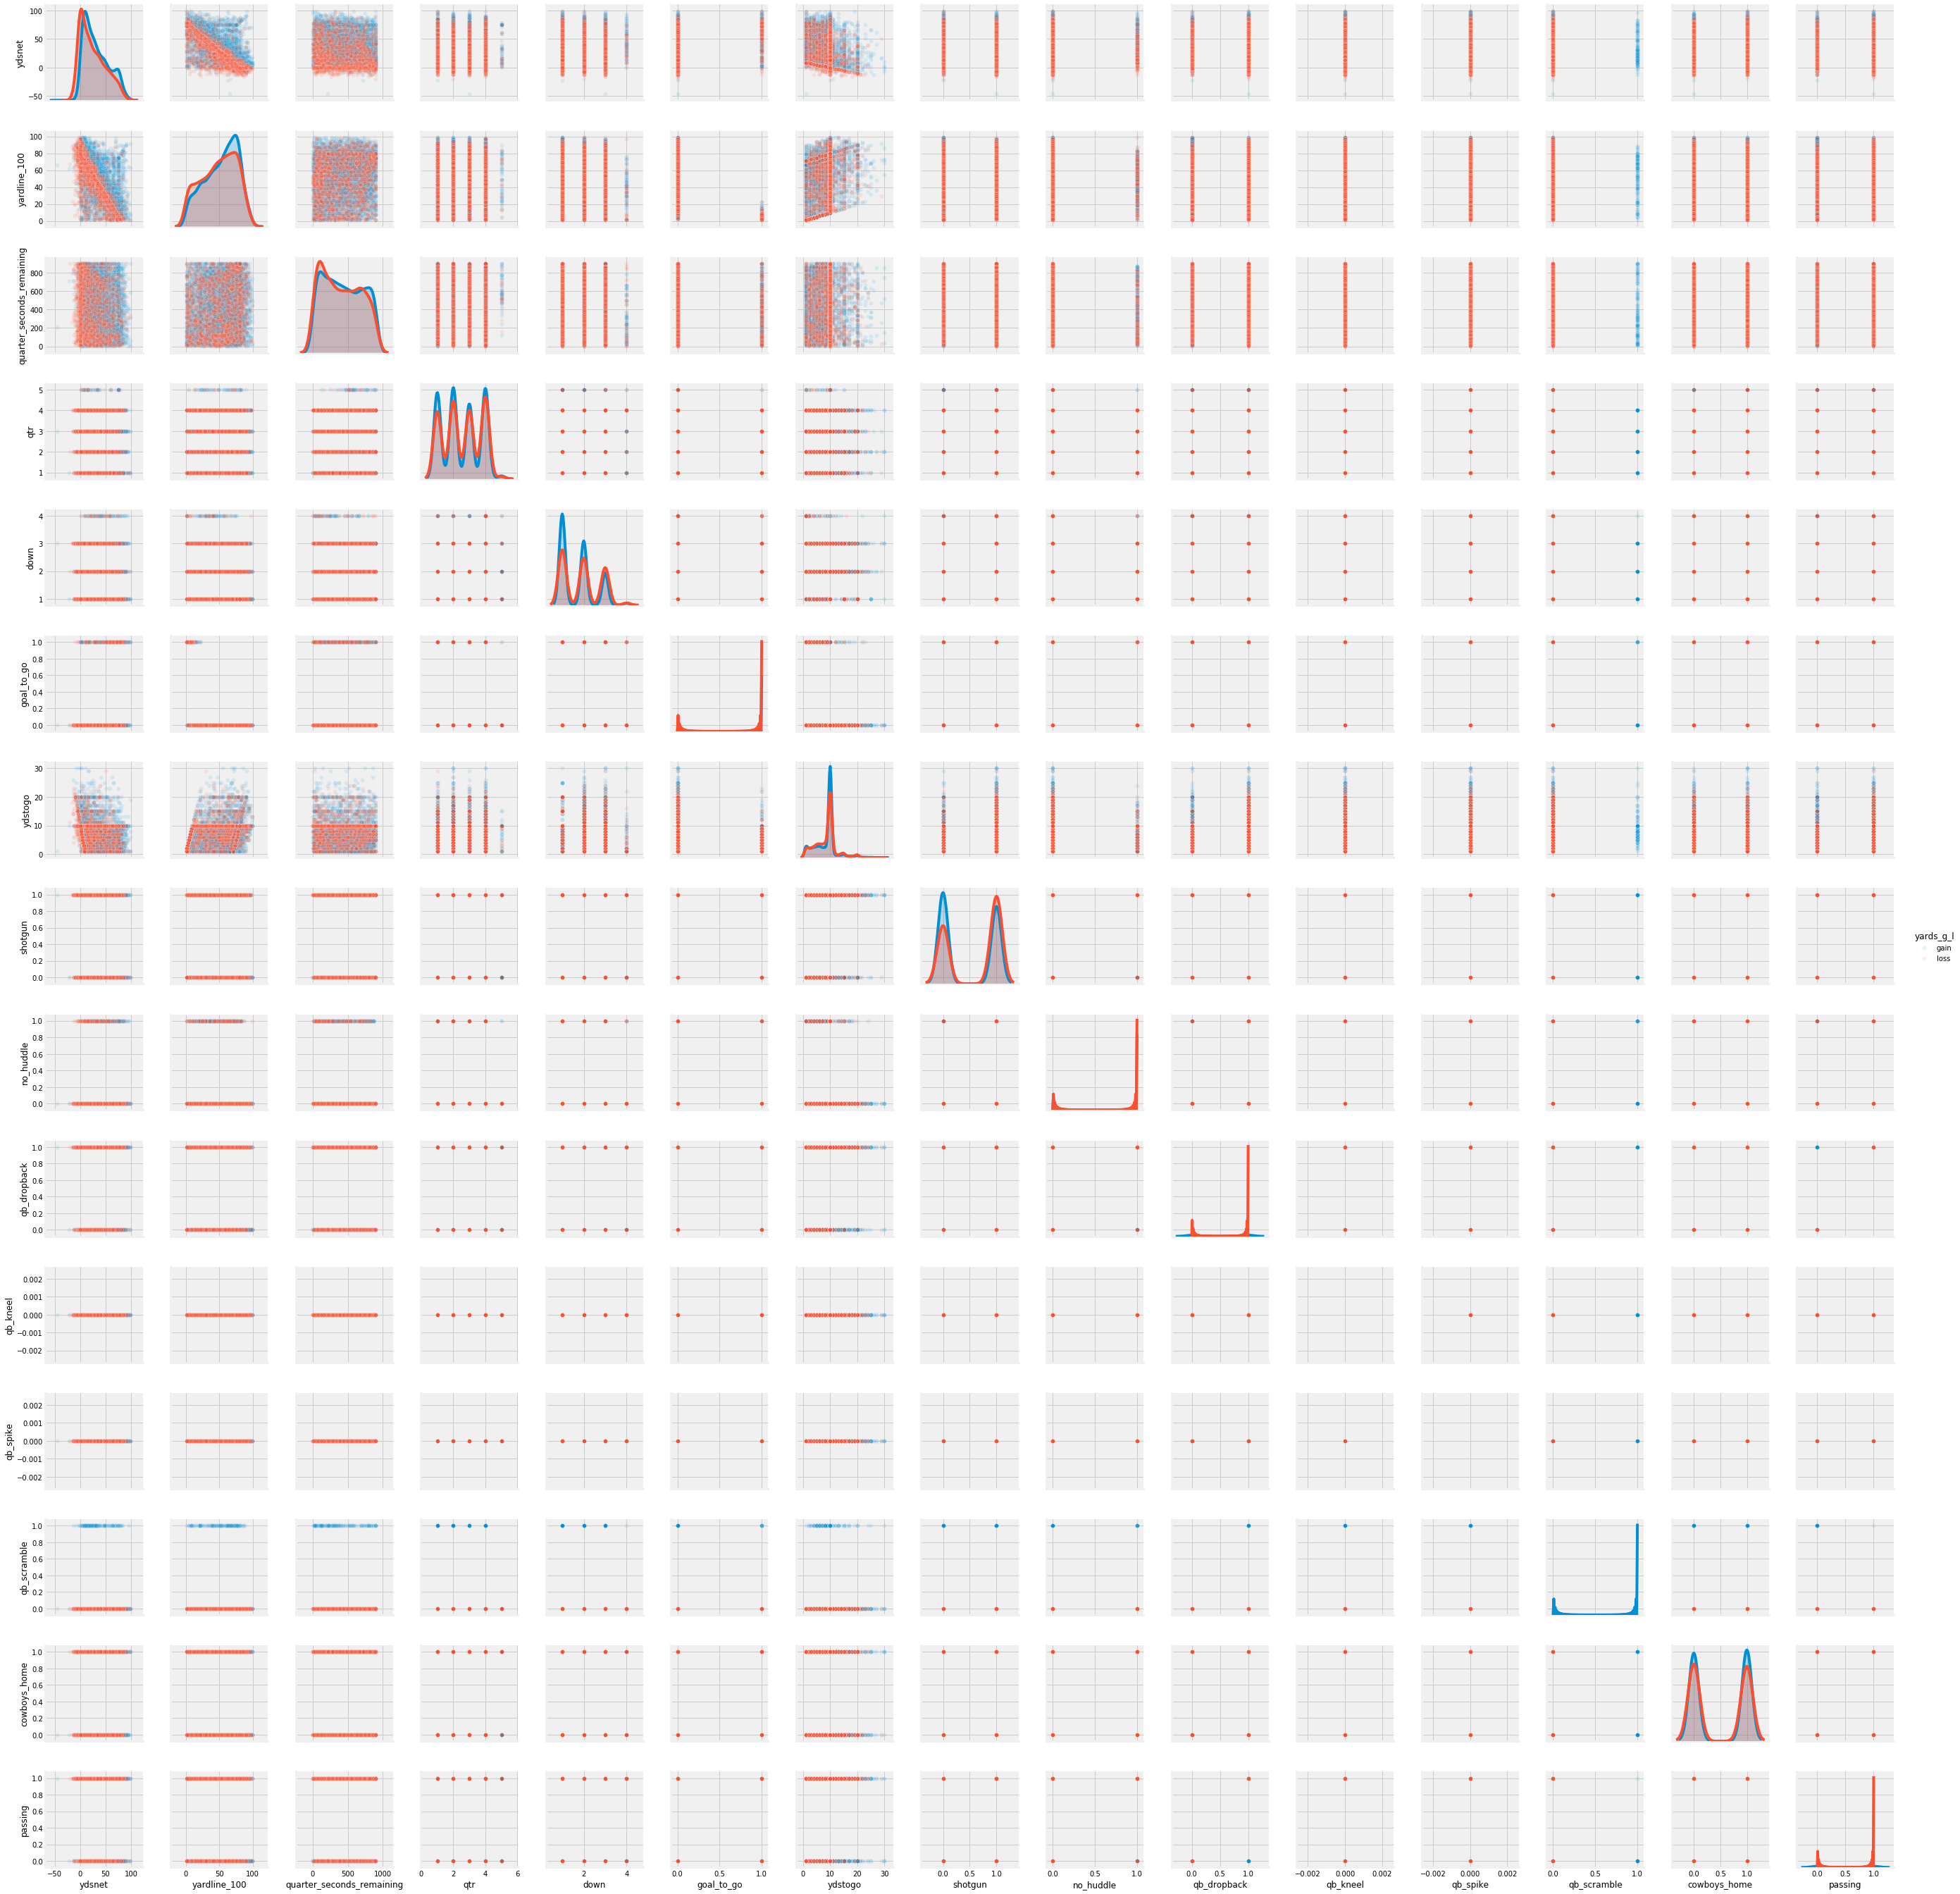

In [30]:
sns.pairplot(train_df, hue='yards_g_l', plot_kws={'alpha': 0.1});

In [31]:
std_scale = StandardScaler()

X_train_scaled = std_scale.fit_transform(X_train)
X_test_scaled = std_scale.fit_transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


## Logistic Regression

In [32]:
model_lr = LogisticRegression(random_state = 22)
model_lr.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=22, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [33]:
model_lr.score(X_test, y_test)

0.7246083880747852

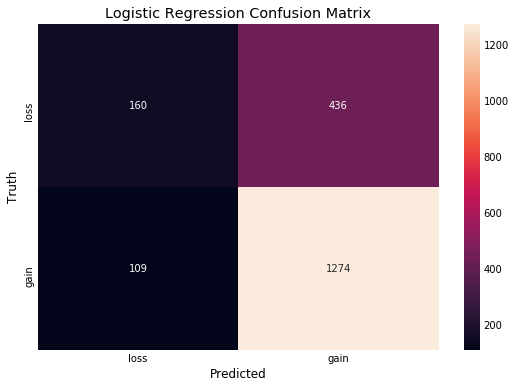

In [34]:
labels = ['loss','gain']

cm_lr = confusion_matrix(y_test, model_lr.predict(X_test), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_lr, annot=True, fmt='g').set_title('Logistic Regression Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');


In [35]:
model_lr_scaled = LogisticRegression(random_state = 12)
model_lr_scaled.fit(X_train_scaled, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=12, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [36]:
model_lr_scaled.score(X_test_scaled, y_test)

0.7225871652349671

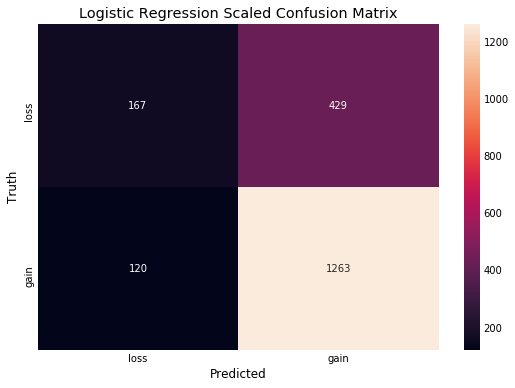

In [37]:
cm_lr_scaled = confusion_matrix(y_test, model_lr_scaled.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_lr_scaled, annot=True, fmt='g').set_title('Logistic Regression Scaled Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [38]:
print(classification_report(y_test, model_lr_scaled.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.58      0.28      0.38       596
        gain       0.75      0.91      0.82      1383

   micro avg       0.72      0.72      0.72      1979
   macro avg       0.66      0.60      0.60      1979
weighted avg       0.70      0.72      0.69      1979



ROC AUC score =  0.7442870522694076


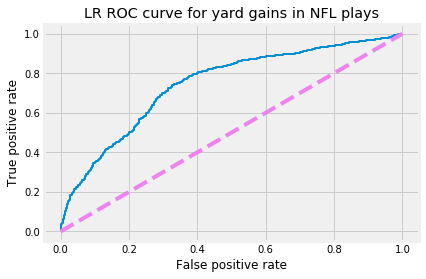

In [39]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_lr_scaled.predict_proba(X_test_scaled)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('LR ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_lr_scaled.predict_proba(X_test_scaled)[:,0]))

## KNN

In [40]:
from sklearn import neighbors
model_knn = neighbors.KNeighborsClassifier()

In [41]:
model_knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [42]:
model_knn.score(X_test_scaled, y_test)

0.6958059626073775

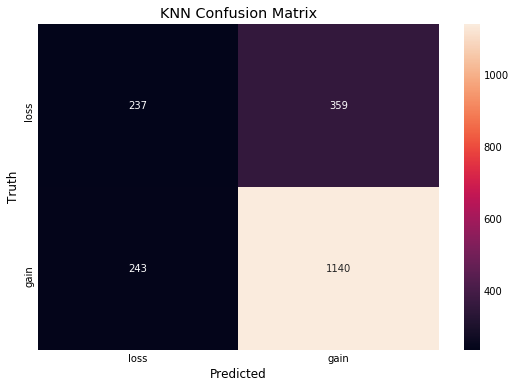

In [43]:
cm_knn = confusion_matrix(y_test, model_knn.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_knn, annot=True, fmt='g').set_title('KNN Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [44]:
print(classification_report(y_test, model_knn.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.49      0.40      0.44       596
        gain       0.76      0.82      0.79      1383

   micro avg       0.70      0.70      0.70      1979
   macro avg       0.63      0.61      0.62      1979
weighted avg       0.68      0.70      0.69      1979



ROC AUC score =  0.6793912902114361


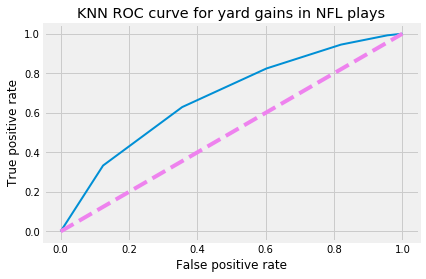

In [45]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_knn.predict_proba(X_test_scaled)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('KNN ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_knn.predict_proba(X_test_scaled)[:,0]))

## SVM

In [46]:
from sklearn.svm import SVC
model_svm = SVC(random_state = 30)

In [47]:
model_svm.fit(X_train_scaled, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=30,
  shrinking=True, tol=0.001, verbose=False)

In [48]:
model_svm.score(X_test_scaled, y_test)

0.7402728650833754

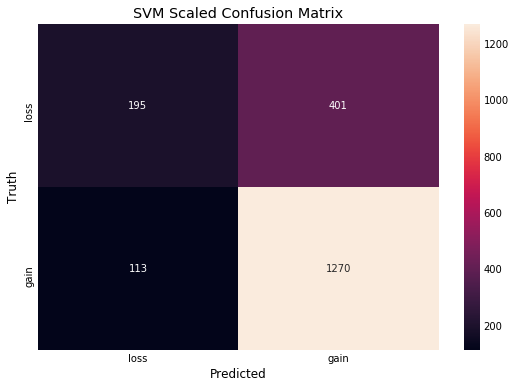

In [49]:
cm_svm = confusion_matrix(y_test, model_svm.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_svm, annot=True, fmt='g').set_title('SVM Scaled Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [50]:
'''svm_test_score = []

for i in [0.1, 1.0, 10.0, 100.0]:
    model_test = SVC(C=i, kernel='linear', random_state = 30)
    model_test.fit(X_train_scaled, y_train)
    svm_test_score.append(model_test.score(X_test_scaled, y_test))

svm_test_score'''

"svm_test_score = []\n\nfor i in [0.1, 1.0, 10.0, 100.0]:\n    model_test = SVC(C=i, kernel='linear', random_state = 30)\n    model_test.fit(X_train_scaled, y_train)\n    svm_test_score.append(model_test.score(X_test_scaled, y_test))\n\nsvm_test_score"

In [51]:
print(classification_report(y_test, model_svm.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.63      0.33      0.43       596
        gain       0.76      0.92      0.83      1383

   micro avg       0.74      0.74      0.74      1979
   macro avg       0.70      0.62      0.63      1979
weighted avg       0.72      0.74      0.71      1979



## Decision Tree

In [52]:
from sklearn import tree

In [53]:
model_tree = tree.DecisionTreeClassifier(max_depth=10, random_state=44)

In [54]:
model_tree.fit(X_train_scaled, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=44,
            splitter='best')

In [55]:
model_tree.score(X_train_scaled, y_train)

0.8435288169868554

In [56]:
model_tree.score(X_test_scaled, y_test)

0.7887822132390097

In [57]:
train_score = []
test_score = []

for i in range(1,21):
    model_test = tree.DecisionTreeClassifier(max_depth=i, random_state=44)
    model_test.fit(X_train_scaled, y_train)
    train_score.append(model_test.score(X_train_scaled, y_train))
    test_score.append(model_test.score(X_test_scaled, y_test))

In [58]:
train_score


[0.7449443882709808,
 0.7449443882709808,
 0.7487360970677452,
 0.7604903943377148,
 0.7697168857431749,
 0.7885490394337715,
 0.7953741152679474,
 0.8114256825075834,
 0.830005055611729,
 0.8435288169868554,
 0.859201213346815,
 0.8763902932254802,
 0.8953488372093024,
 0.9148129423660263,
 0.9342770475227502,
 0.9519716885743175,
 0.9629676440849343,
 0.9749747219413549,
 0.9806622851365016,
 0.9864762386248737]

In [59]:
test_score

[0.7518948964123294,
 0.7518948964123294,
 0.7554320363820111,
 0.7609903991915109,
 0.7700859019706923,
 0.7736230419403739,
 0.7731177362304194,
 0.7741283476503285,
 0.7822132390096008,
 0.7887822132390097,
 0.786255684689237,
 0.7822132390096008,
 0.7614957049014653,
 0.7625063163213744,
 0.7498736735725113,
 0.7433046993431026,
 0.7387569479535119,
 0.7392622536634664,
 0.732187973724103,
 0.7412834765032845]

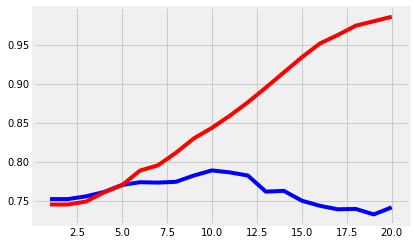

In [60]:
plt.plot(range(1,21), test_score, 'b', range(1,21), train_score, 'r')
plt.show()

# using max_depth of 10 gives best result on test set

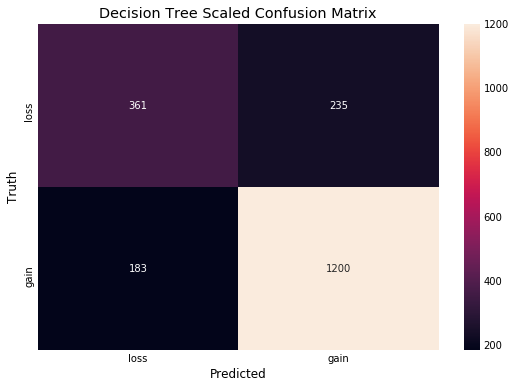

In [61]:
cm_tree = confusion_matrix(y_test, model_tree.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_tree, annot=True, fmt='g').set_title('Decision Tree Scaled Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [62]:
print(classification_report(y_test, model_tree.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.66      0.61      0.63       596
        gain       0.84      0.87      0.85      1383

   micro avg       0.79      0.79      0.79      1979
   macro avg       0.75      0.74      0.74      1979
weighted avg       0.78      0.79      0.79      1979



ROC AUC score =  0.7920433645367768


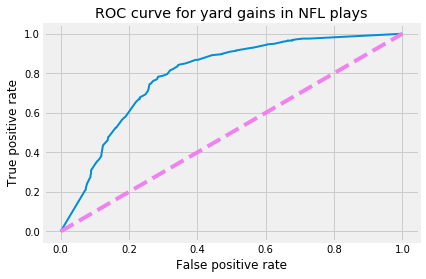

In [63]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_tree.predict_proba(X_test_scaled)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_tree.predict_proba(X_test_scaled)[:,0]))

## Naive Bayes - Gaussian

In [64]:
from sklearn import naive_bayes

In [65]:
model_NB_Gaus = naive_bayes.GaussianNB()

In [66]:
model_NB_Gaus.fit(X_train_scaled, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [67]:
model_NB_Gaus.score(X_test_scaled, y_test)

0.32036382011116726

## Extra Trees

In [68]:
from sklearn import ensemble

In [69]:
model_xtrees = ensemble.ExtraTreesClassifier(n_estimators=100, random_state=15)

In [70]:
model_xtrees.fit(X_train_scaled, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
           oob_score=False, random_state=15, verbose=0, warm_start=False)

In [71]:
model_xtrees.score(X_test_scaled, y_test)

0.7549267306720566

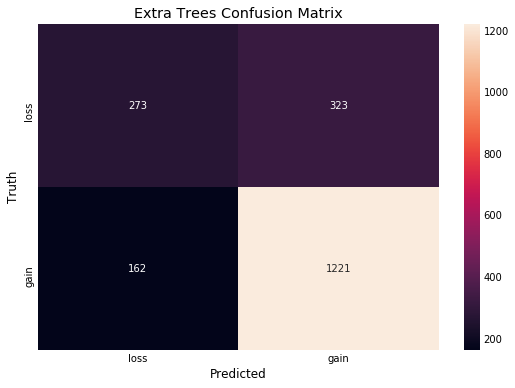

In [72]:
cm_xtrees = confusion_matrix(y_test, model_xtrees.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_xtrees, annot=True, fmt='g').set_title('Extra Trees Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [73]:
print(classification_report(y_test, model_xtrees.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.63      0.46      0.53       596
        gain       0.79      0.88      0.83      1383

   micro avg       0.75      0.75      0.75      1979
   macro avg       0.71      0.67      0.68      1979
weighted avg       0.74      0.75      0.74      1979



ROC AUC score =  0.7704909082968161


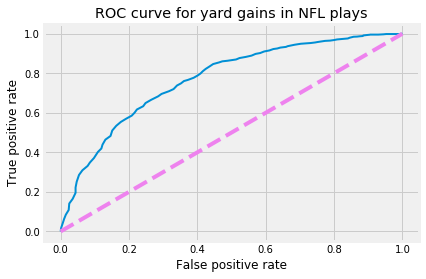

In [74]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_xtrees.predict_proba(X_test_scaled)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_xtrees.predict_proba(X_test_scaled)[:,0]))

## Random Forest

In [75]:
model_rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=15)


In [76]:
model_rf.fit(X_train_scaled, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=15, verbose=0, warm_start=False)

In [77]:
model_rf.score(X_test_scaled, y_test)

0.7832238504295098

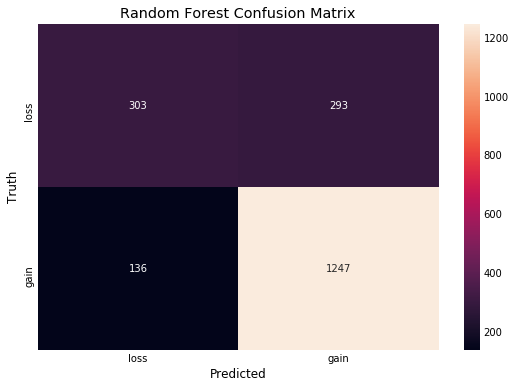

In [78]:
cm_rf = confusion_matrix(y_test, model_rf.predict(X_test_scaled), labels)

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
sns.heatmap(cm_rf, annot=True, fmt='g').set_title('Random Forest Confusion Matrix')
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)
plt.xlabel('Predicted')
plt.ylabel('Truth');

In [79]:
print(classification_report(y_test, model_rf.predict(X_test_scaled), labels))

              precision    recall  f1-score   support

        loss       0.69      0.51      0.59       596
        gain       0.81      0.90      0.85      1383

   micro avg       0.78      0.78      0.78      1979
   macro avg       0.75      0.71      0.72      1979
weighted avg       0.77      0.78      0.77      1979



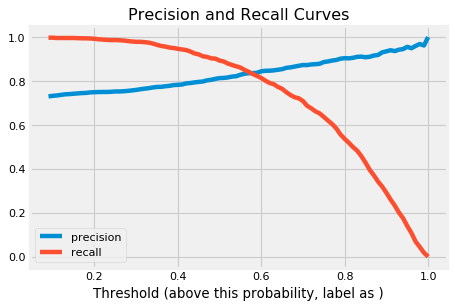

In [80]:
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test_binary, model_rf.predict_proba(X_test_scaled)[:,0] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as )');
plt.title('Precision and Recall Curves');


In [81]:
threshold = 0.46

predicted_proba = model_rf.predict_proba(X_test_scaled)
predicted = (predicted_proba [:,0] >= threshold).astype('int')

print(classification_report(y_test_binary, predicted))

              precision    recall  f1-score   support

           0       0.71      0.45      0.55       596
           1       0.80      0.92      0.85      1383

   micro avg       0.78      0.78      0.78      1979
   macro avg       0.75      0.69      0.70      1979
weighted avg       0.77      0.78      0.76      1979



In [82]:
threshold = np.arange(.40,.60,.01)

for i in threshold:
    predicted_proba = model_rf.predict_proba(X_test_scaled)
    predicted = (predicted_proba [:,0] >= i).astype('int')

    print(f1_score(y_test_binary, predicted))

0.8574225122349102
0.8562992125984251
0.8581794195250659
0.8564799469671859
0.8544726301735647
0.853887399463807
0.8512647554806071
0.8528813559322035
0.8513974096796182
0.8532329798152583
0.8511371467953137
0.8496370549602489
0.8465019143752174
0.8455341506129598
0.8437719915552427
0.8443814250265863
0.8415026833631486
0.8386167146974064
0.8336353751359189
0.8300510576221735


ROC AUC score =  0.8090366240106374


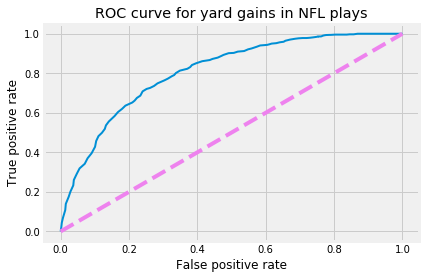

In [83]:
fpr, tpr, thresholds = roc_curve(y_test_binary, model_rf.predict_proba(X_test_scaled)[:,0])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for yard gains in NFL plays');
print("ROC AUC score = ", roc_auc_score(y_test_binary, model_rf.predict_proba(X_test_scaled)[:,0]))

#### Random Forest - Feature Importance - sklearn default

In [84]:
from sklearn.feature_selection import SelectFromModel

In [85]:
sel = SelectFromModel(ensemble.RandomForestClassifier(n_estimators = 100, random_state = 15))
sel.fit(X_train_scaled, y_train)
sel.get_support()

array([ True,  True,  True, False, False, False,  True, False, False,
       False, False, False, False, False, False])

In [86]:
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

Index(['ydsnet', 'yardline_100', 'quarter_seconds_remaining', 'ydstogo'], dtype='object')


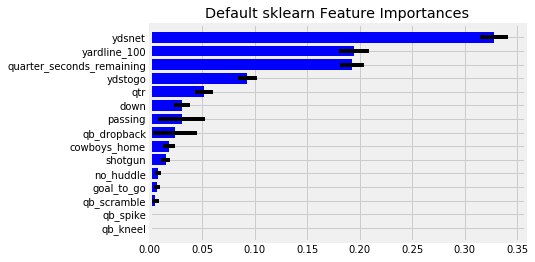

In [87]:
importances = model_rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in model_rf.estimators_],
             axis=0)
indices = np.argsort(importances)

# Plot the feature importances of the forest
plt.figure()
plt.title("Default sklearn Feature Importances")
plt.barh(range(X_train_scaled.shape[1]), importances[indices],
       color="b", xerr=std[indices], align="center")
# If you want to define your own labels,
# change indices to a list of labels on the following line.
plt.yticks(range(X_train_scaled.shape[1]), [X_train.columns[i] for i in indices])
plt.ylim([-1, X_train_scaled.shape[1]])
plt.show()

#### Random Forest - Feature Importance - rfpimp version

https://github.com/parrt/random-forest-importances

In [88]:
from rfpimp import *

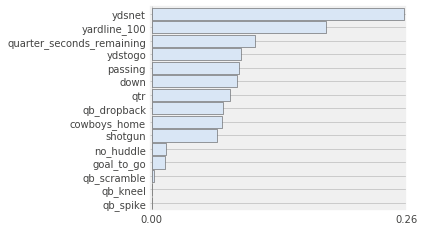

In [89]:
model_rf2 = ensemble.RandomForestClassifier(n_estimators=100, random_state=15)
model_rf2.fit(X_train, y_train)

imp = importances(model_rf2, X_train, y_train) # permutation
viz = plot_importances(imp, width=6)
viz.view()


Top 7 features in both cases are ydsnet, yardline_100, ydstogo, quarter_seconds_remaining, qtr, down, and passing